In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

buffer_dir = '/p/crash/amago-multi-car-20251202/multi-car-20251202_crash-v0_trial_0/buffer/protected'

print('Listing files in protected buffer directory:')
buffer_list = os.listdir(buffer_dir)

def get_starting_states(file_path):
    with np.load(file_path) as data:
        first_state = data['_OBS_KEY_observation'][0] # First observation
        num_cars = np.sum(first_state[:, 0])
        dist_to_cars = np.linalg.norm(first_state[0, 1:3] - first_state[1:int(num_cars), 1:3], axis=1)
        relative_velocities = first_state[1:int(num_cars), 3] - first_state[0, 3]
    ttc = dist_to_cars / np.maximum(relative_velocities, 1e-5)
    # Sort by distance to ego car
    sorted_indices = np.argsort(dist_to_cars)
    dist_to_cars = dist_to_cars[sorted_indices]
    relative_velocities = relative_velocities[sorted_indices]
    ttc = ttc[sorted_indices]
    stats = {
        'num_cars': int(num_cars),
        'dist_to_cars': dist_to_cars,
        'relative_velocities': relative_velocities,
        'ttc': ttc
    }
    return stats

episode_stats = []
for file_name in tqdm(buffer_list):
    file_path = os.path.join(buffer_dir, file_name)
    stats = get_starting_states(file_path)
    episode_stats.append(stats)



Listing files in protected buffer directory:


  0%|          | 4721/1394353 [00:03<17:18, 1337.80it/s]


KeyboardInterrupt: 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

buffer_dir = '/p/crash/amago-multi-car-20251202/multi-car-20251202_crash-v0_trial_0/buffer/protected'

# 1. Define the worker function at the top level (required for multiprocessing)
def process_single_file(file_path):
    min_ttc_x = np.inf
    min_ttc_y = np.inf
    try:
        with np.load(file_path) as data:
            # Only load the specific key we need
            data = data['_OBS_KEY_observation']
            for i in range(data.shape[0]):

                for num_car in range(1, data.shape[1]):
                    # Ego Car States
                    ego_x = data[i, 0, 1]
                    ego_y = data[i, 0, 2]
                    ego_vx = data[i, 0, 3]
                    ego_vy = data[i, 0, 4]

                    if data[i, num_car, 0] == 0:
                        continue
                    # Process the observation to extract stats
                    x = data[i, num_car, 1]
                    y = data[i, num_car, 2]
                    vx = data[i, num_car, 3]
                    vy = data[i, num_car, 4]

                    # Longitudinal TTC (x direction)
                    dx = ego_x - x
                    dvx = ego_vx - vx

                    if abs(dx) < 1e-5:
                        ttc_x = 0.0
                    elif abs(dvx) < 1e-5:
                        ttc_x = np.inf * np.sign(dx)
                    else:
                        ttc_x = dx / dvx

                    # Lateral TTC (y direction)
                    dy = ego_y - y
                    dvy = ego_vy - vy
                    if abs(dy) < 1e-5:
                        ttc_y = 0.0
                    elif abs(dvy) < 1e-5:
                        ttc_y = np.inf * np.sign(dy)
                    else:
                        ttc_y = dy / dvy

                    min_ttc_x = min(min_ttc_x, abs(ttc_x))
                    min_ttc_y = min(min_ttc_y, abs(ttc_y))

        return (min_ttc_x, min_ttc_y)


            
    except Exception as e:
        # Handle corrupt files or empty arrays gracefully
        return None


In [17]:
print('Listing files in protected buffer directory...')
buffer_list = os.listdir(buffer_dir)

# Pre-calculate full paths to avoid doing it inside the worker
file_paths = [os.path.join(buffer_dir, f) for f in buffer_list]


# Use number of cores available
num_workers = cpu_count()
print(f"Processing with {num_workers} workers...")

episode_stats = []

# 2. Create the Pool
with Pool(num_workers) as p:
    # imap_unordered is generally faster if you don't care about the order 
    # of the results matching the order of the input list.
    # If you DO care about order, change to p.imap
    results = list(tqdm(p.imap(process_single_file, file_paths), total=len(file_paths)))

# Filter out any Nones from failed reads
episode_stats = [r for r in results if r is not None]

print(f"Done. Processed {len(episode_stats)} files.")

Listing files in protected buffer directory...


Processing with 20 workers...


100%|██████████| 1394353/1394353 [13:43<00:00, 1693.91it/s]


Done. Processed 1394353 files.


In [3]:
# Load Merge Evals
twoway_eval_dir = '/p/crash/amago_eval_two-way-v0_trajectories'
twoway_data_list = os.listdir(twoway_eval_dir)

twoway_file_paths = [os.path.join(twoway_eval_dir, f) for f in twoway_data_list]

# Use number of cores available
num_workers = cpu_count()
print(f"Processing with {num_workers} workers...")

twoway_episode_stats = []

# 2. Create the Pool
with Pool(num_workers) as p:
    # imap_unordered is generally faster if you don't care about the order 
    # of the results matching the order of the input list.
    # If you DO care about order, change to p.imap
    results = list(tqdm(p.imap(process_single_file, twoway_file_paths), total=len(twoway_file_paths)))

# Filter out any Nones from failed reads
twoway_episode_stats = [r for r in results if r is not None]

print(f"Done. Processed {len(twoway_episode_stats)} files.")

Processing with 20 workers...


100%|██████████| 12932/12932 [00:07<00:00, 1678.13it/s]

Done. Processed 12932 files.


In [2]:
# Load Merge Evals
merge_eval_dir = '/p/crash/amago_eval_merge-v0_trajectories'
merge_data_list = os.listdir(merge_eval_dir)

merge_file_paths = [os.path.join(merge_eval_dir, f) for f in merge_data_list]


# Use number of cores available
num_workers = cpu_count()
print(f"Processing with {num_workers} workers...")

merge_episode_stats = []

# 2. Create the Pool
with Pool(num_workers) as p:
    # imap_unordered is generally faster if you don't care about the order 
    # of the results matching the order of the input list.
    # If you DO care about order, change to p.imap
    results = list(tqdm(p.imap(process_single_file, merge_file_paths), total=len(merge_file_paths)))

# Filter out any Nones from failed reads
merge_episode_stats = [r for r in results if r is not None]

print(f"Done. Processed {len(merge_episode_stats)} files.")

Processing with 20 workers...


100%|██████████| 6774/6774 [00:04<00:00, 1385.41it/s]

Done. Processed 6774 files.


100%|██████████| 12932/12932 [00:00<00:00, 1289236.06it/s]


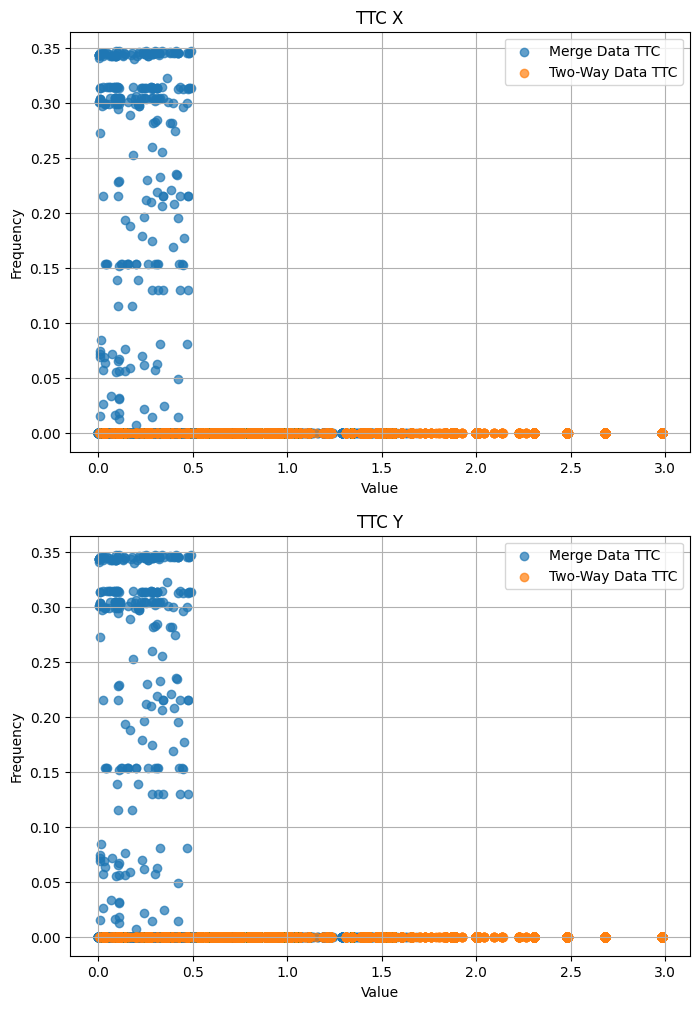

In [ ]:
## Scatter Plots of Minimum Time To Collision
min_ttc_x_values = []
min_ttc_y_values = []

min_ttc_x_values_merge = []
min_ttc_y_values_merge = []

min_ttc_x_values_twoway = []
min_ttc_y_values_twoway = []

# for stats in tqdm(episode_stats):
#     min_ttc_x_values.append(stats[0])
#     min_ttc_y_values.append(stats[1])

for stats in tqdm(merge_episode_stats):
    min_ttc_x_values_merge.append(stats[0])
    min_ttc_y_values_merge.append(stats[1])

for stats in tqdm(twoway_episode_stats):
    min_ttc_x_values_twoway.append(stats[0])
    min_ttc_y_values_twoway.append(stats[1])

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
# ax[0].hist(min_ttc_x_values, bins = np.arange(0, 10, 0.5), label = "Training Data TTC X")
# ax[0].hist(min_ttc_x_values_merge, bins = np.arange(0, 10, 0.5), label = "Merge Data TTC X", alpha=0.7)
# ax[0].hist(min_ttc_x_values_twoway, bins = np.arange(0, 10, 0.5), label = "Two-Way Data TTC X", alpha=0.7)
ax[0].scatter(min_ttc_x_values_merge, min_ttc_y_values_merge, label = "Merge Data TTC", alpha=0.7)
ax[0].scatter(min_ttc_x_values_twoway, min_ttc_y_values_twoway, label = "Two-Way Data TTC", alpha=0.7)
ax[0].set_title(f'TTC X')
ax[0].set_xlabel('TTC X Value')
ax[0].set_ylabel('TTC Y Value')
# ax[0].set_xlim(0, 10)
# ax[0].set_ylim(0, 5000)
ax[0].grid(True)
ax[0].legend()

# ax[1].hist(min_ttc_y_values, bins = np.arange(0, 10, 0.5), label = "Training Data TTC Y")
# ax[1].hist(min_ttc_y_values_merge, bins = np.arange(0, 10, 0.5), label = "Merge Data TTC Y", alpha=0.7)
# ax[1].hist(min_ttc_y_values_twoway, bins = np.arange(0, 10, 0.5), label = "Two-Way Data TTC Y", alpha=0.7)
ax[1].scatter(min_ttc_x_values_merge, min_ttc_y_values_merge, label = "Merge Data TTC", alpha=0.7)
ax[1].scatter(min_ttc_x_values_twoway, min_ttc_y_values_twoway, label = "Two-Way Data TTC", alpha=0.7)
ax[1].set_title(f'TTC Y')
ax[1].set_xlabel('TTC X Value')
ax[1].set_ylabel('TTC Y Value')
# ax[1].set_xlim(0, 10)
# ax[1].set_ylim(0, 5000)
ax[1].grid(True)
ax[1].legend()
plt.show()
    